In [1]:
# Description
"""

Last modified 11.02.2016
    Added mongoDB support
    pandas avr_table dumps to csv file in 'folder' directory 

08.02.2016
Pandas functionality added, now can be saved to database

New - sifting works correctly, 
        in dataD images which are sifted indicated as isgood=False, 
        fits now use parame
        ter sigma = 'yerr' to calculate fit,
        

""";

In [2]:
# Imports and initialization
%pylab inline

import sys
import os
par_dir = os.path.split(os.getcwd())[0]
if par_dir not in sys.path:
    sys.path.append(par_dir)
import inspect
import pickle
import imp
import re
import json
from scipy.optimize import curve_fit
import pandas as pd

# from IPython.html import widgets
# from IPython.display import display
# from IPython.html.widgets import interact, interactive, fixed


import thulium_python_lib.usefull_functions as usfuncs
import thulium_python_lib.image_processing_new as impr

import ipyparallel as ipp
ipp.CompositeError.tb_limit = 1

rc1 = ipp.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
dview['par_dir'] = par_dir
# with dview.sync_imports():
#     import sys, os    
%px import sys, os
%px if par_dir not in sys.path: sys.path.append(par_dir)
%px import thulium_python_lib.image_processing_new as impr
%px import imp
# %px from ipyparallel import bind_kernel; bind_kernel()

import datetime
import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId

# start mongoDB client (mongod server should be launched)
# client = MongoClient('mongodb://localhost:27017/')
client = MongoClient('mongodb://192.168.1.15:27017/')
meas_database = client.measData.meas_data

Populating the interactive namespace from numpy and matplotlib
Done importing, module image_processing now


In [3]:
# to reload library on remote and local engine
%px imp.reload(impr)
imp.reload(impr)
# imp.reload(usfuncs)

[stdout:0] Done importing, module image_processing now
[stdout:1] Done importing, module image_processing now
[stdout:2] Done importing, module image_processing now
[stdout:3] Done importing, module image_processing now


Out[0:141]: <module 'thulium_python_lib.image_processing_new' from 'U:\\thulium_python_lib\\image_processing_new.py'>

Out[1:141]: <module 'thulium_python_lib.image_processing_new' from 'U:\\thulium_python_lib\\image_processing_new.py'>

Out[2:141]: <module 'thulium_python_lib.image_processing_new' from 'U:\\thulium_python_lib\\image_processing_new.py'>

Out[3:141]: <module 'thulium_python_lib.image_processing_new' from 'U:\\thulium_python_lib\\image_processing_new.py'>

Done importing, module image_processing now


<module 'thulium_python_lib.image_processing_new' from 'U:\\thulium_python_lib\\image_processing_new.py'>

### And now:
#### Choose working directory and measurement folder

In [1173]:
# smth like 'D:\!Data\2015_08_20' for lab and like '/Users/artemgolovizin/Downloads/2015_08_20' for mac
os.chdir(r'\\BIGONE\!Data\2016_05_11')
# os.chdir(r'/Users/artemgolovizin/Downloads/2015_08_20/')
# print('Current directory', os.getcwd());
current_directory = os.path.split(os.getcwd())[-1]
# Create folder 'Figures' for saving individual plot
if not os.path.exists('Figures'):
    os.makedirs('Figures')
    print('Folder Figures has been created')
working_directory = ''
folder = ''

Folder Figures has been created


In [1725]:
# specify working folder
folder = '34 as 20 a=-2dBm/'
working_directory = os.path.join(os.getcwd(),folder)
# print('Working directory', working_directory)

dirs = [x for x in os.listdir() if re.match('\d',x)]
meas_type, conf_params, x_lbl, y_lbl, xaxis_calib = impr.get_x_calibration(folder, dirs)

### Load data, rearange, average and calibrate
 Constract loader and averager. For available parameters see help('instance')

In [1726]:
# create loader
loader  = impr.Load_Image(dview)
# downloading images
all_data = loader(working_directory,lview)

# rearranging to dictionary
dataD = impr.rearrange_data(all_data)

  63/63 tasks finished after    1 s
done

Total number of images:  63
Rearranging to dictionary is complited


In [1727]:
# create averager
averager = impr.Avr_Image(dview,do_sifting=True,conf_int=0.1)
# averaging data and fitting
avr_dataD = averager(dataD,lview)

# construct new data dictionary without image and calibration atoms number, size and x-axis
#navrD = impr.mod_avrData(avr_dataD, xaxis_calib, impr.N_atoms(width=0.5, delta = 5), impr.real_size)
gain_tmp=200 # 2016_05_04, 2016_05_11, 2016_05_12
#gain_tmp=300 # 2016_05_05
#gain_tmp=400 # 2016_05_06, 2016_05_07, 2016_05_08
navrD = impr.mod_avrData(avr_dataD, xaxis_calib, impr.N_atoms(gain=gain_tmp, exposure=200, power=6.3, width=1.85, delta = 5), impr.real_size)

avr_table = impr.get_pandas_table2(navrD)
# for plotting sifted image

#imshow(imread('1 от частоты амплитудной модуляции аома верди (5) 3.9W/26ms/2_1.png'))
#colorbar()

   9/9 tasks finished after    1 s
done
0 images are sifted in folder=0.000000,shot_typeN=1
0 images are sifted in folder=1.000000,shot_typeN=1
0 images are sifted in folder=3.000000,shot_typeN=1
0 images are sifted in folder=4.000000,shot_typeN=1
0 images are sifted in folder=5.000000,shot_typeN=1
0 images are sifted in folder=7.000000,shot_typeN=1
0 images are sifted in folder=8.000000,shot_typeN=1
0 images are sifted in folder=9.000000,shot_typeN=1
0 images are sifted in folder=10.000000,shot_typeN=1



In [1728]:
#plot(sum(avr_dataD[8][1].image,0))
#print(avr_dataD[8][1].image.shape)

In [1729]:
# convention table for filenames
# impr.meas_types

In [1730]:
#imshow(avr_dataD[9][1.0].image,vmax=0.02)
#colorbar()

### Construct data based on measurement type and plot

In [1731]:
def cloud_expansion_fixed_t0(x,T,r0,t0):
    return usfuncs.cloud_expansion(x,T,r0,6)

Fit parameters X, Y:
T =   35.17	93.41
r0 =   467.45	871.34
Number of atoms 2973996.6220441363 +- 66393.94981696625


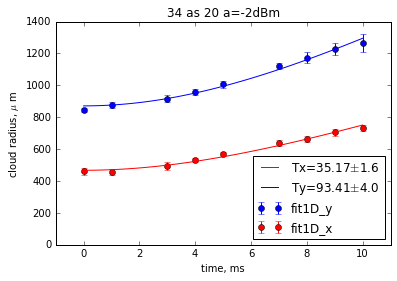

In [1732]:
# shot_typeN - for now only 1, if there will be calibration - 1 or more
shot_typeN = 1

# description to add to all_data.txt file
description = dict()
description['meas_type'] = meas_type
description['x_label'] = x_lbl
description['y_label'] = y_lbl

# meas_type = 'T' # here one can specify type to get desired plots
# meas_type = 'LT'
fit_func = None
fits_list = []
fig1, ax1 = subplots()
if meas_type == 'T':
    # construct data with cloud expansion on both coordinates
    # first set of data  - Temperature X
    d1 = impr.get_avr_data(navrD, shot_typeN, 'fit1D_x',2)
    d1['fmt']='ro'
    d1['label']='fit1D_x'
#    impr.drop_by_number(d1,8)
#    impr.drop_by_x(d1,130,160)

    # second set of data  - Temperature Y
    d2 = impr.get_avr_data(navrD, shot_typeN,  'fit1D_y',2)
    d2['fmt']='bo'
    d2['label'] = 'fit1D_y'
#    impr.drop_by_number(d2,8)
#     impr.drop_by_x(d2,14)
    
    # fit cloud expansion
    fit_func = usfuncs.cloud_expansion0
#     fit_func = cloud_expansion_fixed_t0
    popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(20,d1['y'][0]),bounds=(0,np.inf))
    perr_T = np.sqrt(np.diag(pcov_T))
    fits_list.append([fit_func.__name__,list(popt_T), list(perr_T)])
    popt_T2, pcov_T2 = curve_fit(fit_func, d2['x'], d2['y'], p0=(20,d2['y'][0]),bounds=(0,np.inf))
    perr_T2 = np.sqrt(np.diag(pcov_T2))
    fits_list.append([fit_func.__name__,list(popt_T2), list(perr_T2)])
    print('Fit parameters X, Y:\n' + usfuncs.construct_fit_description(fit_func, list(zip(popt_T,popt_T2))))
    
    # plot data and fits 
    ax1.errorbar(**d2)
    ax1.errorbar(**d1)
    xx1 = linspace(min(d1['x']),max(d1['x']),100)
    ax1.plot(xx1, fit_func(xx1,*popt_T),'r', label='Tx=%.2f$\pm$%.1f'%(popt_T[0],perr_T[0]))
    xx2=linspace(min(d2['x']),max(d2['x']),100)
    ax1.plot(xx2, fit_func(xx2,*popt_T2), 'b', label='Ty=%.2f$\pm$%.1f'%(popt_T2[0],perr_T2[0]))
    ax1.set_xlim(min(d1['x'])-1, max(d1['x'])+1)
    # add information about fits to description
    description['fit1D_x'] =  popt_T
    description['fit1D_y'] =  popt_T2
    description['fit-function'] = fit_func.__name__
else:
    #construct data, param - what value to use
    param = ['fit1D_x',0]
    d1 = impr.get_avr_data(navrD, shot_typeN, *param)
    d1['fmt']='ro'
    d1['label']=param
#     impr.drop_by_number(d1,0,1,2)
    #impr.drop_by_x(d1,130,160)
    
    # fit_func - which function to use to fit data  here one can put conditions on meas_type to choose fit
    popt_T = None
#     fit_func = usfuncs.exp_decay_no_bg
#     popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0], 100))
    #popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(-d1['y'][0], d1['x'][argmin(d1['y'])],0.1,d1['y'][0]))
    #print('Fit parameters:\n' + usfuncs.construct_fit_description(fit_func, popt_T))
    perr_T = np.sqrt(np.diag(pcov_T))
    
    # plot data and fits
    ax1.errorbar(**d1)
    if fit_func != None:
        ax1.plot(linspace(min(d1['x']),max(d1['x']),100), fit_func(linspace(min(d1['x']),max(d1['x']),100),*popt_T),'k', label='fit X')
        fit_label = fit_func.__name__ + ' fit:\n' + usfuncs.construct_fit_description(fit_func, list(zip(popt_T,perr_T)),sep='$\pm$')
        ax1.text(0.01,0.01,fit_label,transform=ax1.transAxes)
        description['fit'] =  popt_T
        description['fit-function'] = fit_func.__name__
        fits_list.append([fit_func.__name__,list(popt_T), list(perr_T)])
    

ax1.set_xlabel(x_lbl)
ax1.set_ylabel(y_lbl)
ax1.set_title(folder.rstrip(r'\/ '))
ax1.set_ylim(bottom=0)
ax1.legend(loc=4)

print('Number of atoms', avr_table.T[0].fit1D_x.N, '+-', avr_table.T[0].fit1D_x_std.N)

(0, 150.0)

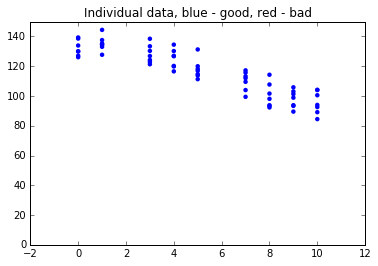

In [1733]:
# for each picture
shot_typeN = 1
xs, ys, cs = impr.constract_data_scatter(dataD, shot_typeN, 'fit1D_y',0)
# plt.figure(figsize=(13,4))
scatter(xs,ys,c=cs,linewidths=0)
title("Individual data, blue - good, red - bad")
ylim(bottom=0)

In [1734]:
# show 2D image
# imshow(avr_dataD[0.2][1].image)

In [1735]:

if folder != '':
    fig1.savefig(os.path.join('Figures',folder.rstrip(r'\/ ')+'.png'))
    # save pandas table to csv file
    avr_table.to_csv(os.path.join(folder,'avr_table.csv'))
    try:
        with open('all_data.txt', 'rb') as handle:
            res_dict = pickle.loads(handle.read())
    except FileNotFoundError:
        res_dict = {}
    except EOFError:
        res_dict = {}
    res_dict[folder.rstrip(r'\/ ')]={'description':description,'data':navrD}
    with open('all_data.txt', 'wb') as handle:
        pickle.dump(res_dict, handle)
    with open('all_data.json', 'w') as outfile:
        json.dump(res_dict, outfile, cls=impr.JsonCustomEncoder, indent=4)    
    print('Figure and data saved!!!')
    
# to later read json file run following two lines
#with open('all_data.json', 'r') as infile:
#        ddata = json.load(infile)

#save to mongo db
# get pickle string of avr_table 
ss = 'temp'
avr_table.to_pickle(ss)
with open(ss,'rb') as fl:
    line = fl.read()
os.remove(ss)
# prepear dictionary to load to mongoDB
data_to_db = {
             'date_meas':datetime.datetime.strptime(current_directory[:10],'%Y_%m_%d'),
             'date_mod':datetime.datetime.now(),
             'folder':folder,
             'meas_type':meas_type,
             'labels':[x_lbl, y_lbl],
              'conf_params':conf_params,
              'fits': fits_list,
              'avr_table_pickle':line
             }
# try to find entery with the same 'date_meas' and 'folder' and either update or create entery
res = meas_database.find_one({'date_meas':datetime.datetime.strptime(current_directory[:10],'%Y_%m_%d'),
                 'folder':folder})
if res:
    print('Entery for folder "%s" updated' % folder)
    meas_database.update_one({'_id':res['_id']},{'$set':data_to_db})
else:
    print('Entery for folder "%s" created' % folder)
    meas_database.insert_one(data_to_db)

Figure and data saved!!!
Entery for folder "34 as 20 a=-2dBm/" created


In [1736]:
from random import shuffle
scans = arange(0,3.1,0.1)
shuffle(scans)
' '.join((str(i) for i in scans))

'1.1 2.1 2.8 1.0 2.0 2.2 0.6 2.7 0.8 2.5 0.2 2.3 2.9 0.1 1.7 1.6 1.9 1.5 3.0 0.7 0.3 0.4 0.9 2.4 1.3 1.4 1.2 2.6 0.0 1.8 0.5'

In [1737]:
x2 = array(aa.ix[aa['type']==1].total)/array(aa.ix[aa['type']==2].total)

NameError: name 'aa' is not defined

In [ ]:
x1 = aa.ix[aa['type']==1].total

In [ ]:
x1.std()/x1.mean()

In [ ]:
x2.std()/x2.mean()

In [ ]:
aa.ix[aa['type']==2].fit1D_y.N.std()

In [ ]:
aa.ix[aa['type']==1][['folder','fit1D_y_std']]/aa.ix[aa['type']==2][['folder','fit1D_y_std']]

In [ ]:
times = []
res1 = []
res2 = []
for key, value in navrD.items():
    times.append(key)
    res1.append(value[1]['fit1D_x'][0])
    res2.append(value[2]['fit1D_x'][0])

In [ ]:
plot(times,res1,'ro')
# plot(times,res2,'bo')
plot(times,array(res1)/(array(res2)/min(array(res2))),'ko')
ylim(bottom=0)

In [ ]:
plot(array(res1)/(array(res2)/max(array(res2))),'o')
ylim(bottom=0)

In [ ]:
def get_value(obj, attribute, index):
    """retruns obj.attibute[index] or obj.attribute if index is not defined"""
    if index != None:
        return getattr(obj,attribute)[index]
    else:
        return getattr(obj,attribute)

In [ ]:
def normalise_individual_image(dictionary, signal_shot, calibration_shot, attribute, index=None, do_fit2D = False):
    """normalize each image using attribute[index] value - usually 'total' or 'x_data_fit[0]'
        returns constracted dictionary (like what returns 'load_data()' function"""
    norm_data = dict()
    for folderN, f_dict in dictionary.items():
        calibrated_images = []
        for s_elem in f_dict[signal_shot]:
            c_elems = [c_elem for c_elem in f_dict[calibration_shot] if c_elem.shotN == s_elem.shotN]
            if c_elems == []:
                print('s_elem.image_url has no calibration image')
                continue
            new_image = impr.Image_Basics(s_elem.image / get_value(c_elems[0],attribute,index))
            new_image.fit1D_x = new_image.fit_gaussian1D(0)
            new_image.fit1D_y = new_image.fit_gaussian1D(1)
            calibrated_images = append(calibrated_images, new_image)
        if calibrated_images != []:
            norm_data[folderN] = dict()
            norm_data[folderN][signal_shot] = calibrated_images
    print('Normalization is complited')
    return norm_data

In [ ]:
bb = normalise_individual_image(dataD, 1, 2, 'fit1D_x', index=0)

In [ ]:
shot_typeN = 1
xs, ys, cs = impr.constract_data_scatter(bb, shot_typeN, 'fit1D_y',0)
# plt.figure(figsize=(13,4))
scatter(xs,ys,c=cs,linewidths=0)
scatter(xs2,ys2/5.3,c='r',linewidths=0)
title("Individual data, blue - good, red - bad")
ylim(bottom=0)

In [ ]:
shot_typeN = 1
xs2, ys2, cs2 = impr.constract_data_scatter(dataD, shot_typeN, 'fit1D_x',0)
xs3, ys3, cs3 = impr.constract_data_scatter(dataD, 2, 'fit1D_x',0)
# plt.figure(figsize=(13,4))
scatter(xs2,ys2/5,c='r',linewidths=0)
title("Individual data, blue - good, red - bad")
ylim(bottom=0)

In [ ]:
# plot(ys2/max(ys2)/(ys3/max(ys3)),'o')
# ys = ys[where(ys>0.5)]
plot(ys/max(ys),'-')
ylim(bottom=0.5)
(ys/max(ys)).std()

In [ ]:
len(ys)

In [ ]:
a = [int(str.split(os.path.split(x.image_url)[-1],'_')[0])  for x in dataD[200][1]]

In [ ]:
plot(ys3/max(ys3))

In [ ]:
(ys2/max(ys2)).std()

In [ ]:
(ys2/max(ys2)/(ys3/max(ys3))).std()

In [ ]:
(ys3/max(ys3)).std()